In [ ]:
#
# ! Select evidently_no_docker virtual env 
# 


import random
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# from sklearn import datasets

# import evidently
from evidently.test_suite import TestSuite
from evidently.test_preset import DataStabilityTestPreset

from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

from evidently.pipeline.column_mapping import ColumnMapping




In [21]:

def generate_datasets() -> None:
    """
    Create two random samples if there are sufficient rows in the dataset.
    """
    # Define the data directory and file paths
    data_dir = Path('../../data')
    fraud_test_file = data_dir / 'fraud_test.csv'
    reference_sample_file = data_dir / 'reference_sample.csv'
    production_sample_file = data_dir / 'production_sample.csv'

    # Check if the input file exists
    if not fraud_test_file.exists():
        print(f"File not found: {fraud_test_file}")
        return

    # Load the dataset
    df = pd.read_csv(fraud_test_file)

    # Determine the number of rows
    num_rows: int = len(df)
    print(f"Number of rows in the dataset: {num_rows}")

    # Stop if there are less than 2000 rows
    if num_rows < 2000:
        print("Not enough rows in the dataset. Exiting.")
        return

    # Take 1_000 random rows for the reference sample
    reference_indices = random.sample(range(num_rows), 1000)
    reference_sample = df.iloc[reference_indices]

    # Take another 1_000 random rows for the production sample (different from the first set)
    remaining_indices = list(set(range(num_rows)) - set(reference_indices))
    production_indices = random.sample(remaining_indices, 1000)
    production_sample = df.iloc[production_indices]

    # Save the samples to their respective files
    reference_sample.to_csv(reference_sample_file, index=False)
    production_sample.to_csv(production_sample_file, index=False)

    print(f"Saved reference sample to: {reference_sample_file}")
    print(f"Saved production sample to: {production_sample_file}")

generate_datasets()


File not found: ..\..\data\fraud_test.csv


In [ ]:
# Replace the path with your actual path
reference = pd.read_csv("../../04_data/reference_sample.csv")
reference.rename(columns={reference.columns[0]: 'id'}, inplace=True)
production = pd.read_csv("../../04_data/production_sample.csv")
production.rename(columns={production.columns[0]: 'id'}, inplace=True)

In [23]:
reference.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,64431,2020-07-13 15:12:23,675990301623,"fraud_Metz, Russel and Metz",kids_pets,9.05,Amanda,Spencer,F,6682 Green Forks,...,41.0767,-74.5982,2456,Senior tax professional/tax inspector,1994-03-13,c1429eb756cee2238738dbd5ce10babf,1373728343,41.842285,-74.537064,0
1,526747,2020-12-25 18:55:00,3566875419572867,fraud_Haag-Blanda,food_dining,63.40,Adam,Mcdonald,M,997 Cameron Meadow Apt. 980,...,44.6400,-73.3113,1654,Transport planner,1991-01-31,65e4b665d37c02f5d7b86b23cb38cdd1,1387997700,44.325739,-72.818688,0
2,64808,2020-07-13 17:10:25,4861310130652566408,"fraud_Larkin, Stracke and Greenfelder",entertainment,48.95,Ashley,Cruz,F,65417 Walsh Radial Suite 691,...,30.2385,-90.8435,10076,"Surveyor, rural practice",1977-12-16,b443beefd7f91049d697863ac79f82ae,1373735425,29.601371,-90.531420,0
3,345858,2020-11-01 20:59:57,3563837241599446,"fraud_Konopelski, Schneider and Hartmann",food_dining,80.53,Timothy,Simmons,M,1049 John Ports Suite 057,...,45.3099,-122.9685,28278,Research scientist (physical sciences),1977-07-17,c7da054429b6b383fe944486b7aa797a,1383339597,45.523465,-122.090825,0
4,456105,2020-12-09 16:55:37,213178765398315,fraud_Schoen-Quigley,kids_pets,15.97,Alan,Colon,M,748 Bryan Fields Suite 935,...,43.0351,-108.2024,19408,"Lecturer, higher education",1993-09-11,89f5ba514d4c2f4b7d27033d02572b6e,1386608137,42.194875,-107.488749,0


In [24]:

# Remove index (first col)
# reference = reference.drop(reference.columns[[0]], axis=1)
# reference.drop(columns=reference.columns[0], inplace=True)
# production.drop(columns=production.columns[0], inplace=True)


# reference = reference.iloc[:, 1:]
# production = production.iloc[:, 1:]
# reference.head()


In [25]:
reference.describe(include='all')

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
count,1000.000000,1000,1.000000e+03,1000,1000,1000.000000,1000,1000,1000,1000,...,1000.000000,1000.000000,1.000000e+03,1000,1000,1000,1.000000e+03,1000.000000,1000.000000,1000.0
unique,NaN,1000,NaN,512,14,NaN,258,352,2,561,...,NaN,NaN,NaN,370,554,1000,NaN,NaN,NaN,NaN
top,NaN,2020-12-24 01:10:16,NaN,fraud_Kilback LLC,gas_transport,NaN,Robert,Smith,F,372 Jeffrey Course,...,NaN,NaN,NaN,Environmental consultant,1977-03-23,3c2c823d776b373caa3e3bc52e297e9b,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,7,104,NaN,18,27,564,8,...,NaN,NaN,NaN,10,10,1,NaN,NaN,NaN,NaN
mean,275998.285000,NaN,4.480148e+17,NaN,NaN,75.063360,NaN,NaN,NaN,NaN,...,38.380368,-89.843471,7.274148e+04,NaN,NaN,NaN,1.380621e+09,38.379979,-89.859075,0.0
std,164071.243744,NaN,1.354934e+18,NaN,NaN,240.817724,NaN,NaN,NaN,NaN,...,5.316149,13.764919,2.536502e+05,NaN,NaN,NaN,5.307367e+06,5.370167,13.788305,0.0
min,2011.000000,NaN,6.042293e+10,NaN,NaN,1.090000,NaN,NaN,NaN,NaN,...,20.027100,-165.672300,2.300000e+01,NaN,NaN,NaN,1.371859e+09,19.757283,-166.250232,0.0
25%,126568.500000,NaN,1.800454e+14,NaN,NaN,9.557500,NaN,NaN,NaN,NaN,...,34.069500,-96.542900,8.932500e+02,NaN,NaN,NaN,1.375598e+09,34.219296,-96.647444,0.0
50%,279839.000000,NaN,3.514202e+15,NaN,NaN,47.150000,NaN,NaN,NaN,NaN,...,39.497600,-86.741150,2.566000e+03,NaN,NaN,NaN,1.380850e+09,39.499162,-86.856119,0.0
75%,417325.500000,NaN,4.658491e+15,NaN,NaN,81.470000,NaN,NaN,NaN,NaN,...,42.177725,-79.862700,1.968500e+04,NaN,NaN,NaN,1.385877e+09,42.035504,-79.988455,0.0


In [26]:
production.describe()

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,279368.854000,3.991583e+17,91.251310,49577.337000,38.533736,-90.630361,8.354757e+04,1.380721e+09,38.550744,-90.625195,0.001000
std,160762.652097,1.280569e+18,686.021471,26749.256923,5.058022,13.606685,2.908501e+05,5.204102e+06,5.078758,13.650366,0.031623
min,3.000000,6.041621e+10,1.010000,1257.000000,20.082700,-165.672300,2.300000e+01,1.371817e+09,21.073887,-166.543650,0.000000
25%,140279.000000,1.800280e+14,9.845000,27837.000000,34.699875,-97.203225,7.557500e+02,1.376064e+09,34.807740,-97.219138,0.000000
50%,274383.000000,3.533918e+15,47.170000,50445.000000,39.433600,-88.361600,2.368000e+03,1.380599e+09,39.559565,-88.408405,0.000000
75%,415734.000000,4.587002e+15,81.885000,72050.000000,41.696875,-80.299250,1.812800e+04,1.385851e+09,41.784026,-80.551778,0.000000
max,555486.000000,4.992346e+18,21437.710000,99783.000000,64.755600,-67.950300,2.906700e+06,1.388529e+09,64.571804,-68.555756,1.000000


In [ ]:
# Fait le liste des colonnes num qu'on veut surveiller
numeric_columns = production.select_dtypes(include="number").columns
ColumnMapping(numerical_features=numeric_columns)

object_columns = production.select_dtypes(include="object").columns
print(object_columns)

ColumnMapping()

column_mapping = ColumnMapping(
    numerical_features=["age", "income"],
    categorical_features=["gender", "occupation"],
    datetime_features=["registration_date"],
    target="is_fraud",
    prediction="predicted_fraud",
    id="id"
)


Index(['trans_date_trans_time', 'merchant', 'category', 'first', 'last',
       'gender', 'street', 'city', 'state', 'job', 'dob', 'trans_num'],
      dtype='object')


ColumnMapping(target='target', prediction='prediction', datetime='datetime', id=None, numerical_features=None, categorical_features=None, datetime_features=None, target_names=None, task=None, pos_label=1, text_features=None, embeddings=None, user_id='user_id', item_id='item_id', recommendations_type=<RecomType.SCORE: 'score'>)

In [12]:
data_stability= TestSuite(tests=[
    DataStabilityTestPreset(), # ici on fait 1 seul test de stabilité
])
data_stability.run(current_data=production, reference_data=reference, column_mapping=None)        # column_mapping ???? 
# data_stability.show("inline")

output_file = "data_stability.html"
data_stability.save_html(output_file)

print(f"Rapport sauvegardé sous le nom {output_file}")


# number of row : faut en avoir au moins 30 et/ou sur une même durée le même nb de lignes

Rapport sauvegardé sous le nom data_stability.html


In [13]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=production, reference_data=reference, column_mapping=None)
# data_drift_report.show("inline")

# Enregistrez le rapport au format HTML
output_file = "./data_drift_report.html"
data_drift_report.save_html(output_file)

print(f"Rapport sauvegardé sous le nom {output_file}")


c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\stats\_stats_py.py:7654: RuntimeWarning:

divide by zero encountered in divide

c:\Users\phili\anaconda3\envs\evidently_no_docker\Lib\site-packages\scipy\st

Rapport sauvegardé sous le nom ./data_drift_report.html


In [14]:
#Export as JSON dict
data_drift_dict = data_drift_report.as_dict()

In [15]:
data_drift_dict

{'metrics': [{'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 22,
    'number_of_drifted_columns': 10,
    'share_of_drifted_columns': 0.45454545454545453,
    'dataset_drift': False}},
  {'metric': 'DataDriftTable',
   'result': {'number_of_columns': 22,
    'number_of_drifted_columns': 10,
    'share_of_drifted_columns': 0.45454545454545453,
    'dataset_drift': False,
    'drift_by_columns': {'amt': {'column_name': 'amt',
      'column_type': 'num',
      'stattest_name': 'K-S p_value',
      'stattest_threshold': 0.05,
      'drift_score': np.float64(0.7593695685682871),
      'drift_detected': False,
      'current': {'small_distribution': {'x': [1.13,
         242.10999999999996,
         483.0899999999999,
         724.0699999999998,
         965.0499999999998,
         1206.03,
         1447.0099999999998,
         1687.9899999999998,
         1928.9699999999998,
         2169.95,
         2410.93],
        'y': [0.004012781143663375,


In [16]:
data_drift_dict["metrics"][0]

{'metric': 'DatasetDriftMetric',
 'result': {'drift_share': 0.5,
  'number_of_columns': 22,
  'number_of_drifted_columns': 10,
  'share_of_drifted_columns': 0.45454545454545453,
  'dataset_drift': False}}

In [17]:
data_drift_dict["metrics"][0]["result"]

{'drift_share': 0.5,
 'number_of_columns': 22,
 'number_of_drifted_columns': 10,
 'share_of_drifted_columns': 0.45454545454545453,
 'dataset_drift': False}

In [18]:
drifted_features = []
drift_by_columns = data_drift_dict['metrics'][1]['result'].get('drift_by_columns', {})

for feature, details in drift_by_columns.items():
    if details['drift_detected']:
        drifted_features.append({
            "feature": feature,
            "drift_score": details.get('drift_score')  # Utilisation du drift_score comme score de dérive
        })

# Génération du DataFrame et affichage
if drifted_features:
    drifted_features_df = pd.DataFrame(drifted_features).sort_values(by="drift_score")
    print(drifted_features_df)
else:
    print("No drift detected")

                 feature  drift_score
0                   city          0.0
1                    dob          0.0
2                  first          0.0
3                    job          0.0
4                   last          0.0
5               merchant          0.0
6                  state          0.0
7                 street          0.0
8  trans_date_trans_time          0.0
9              trans_num          0.0


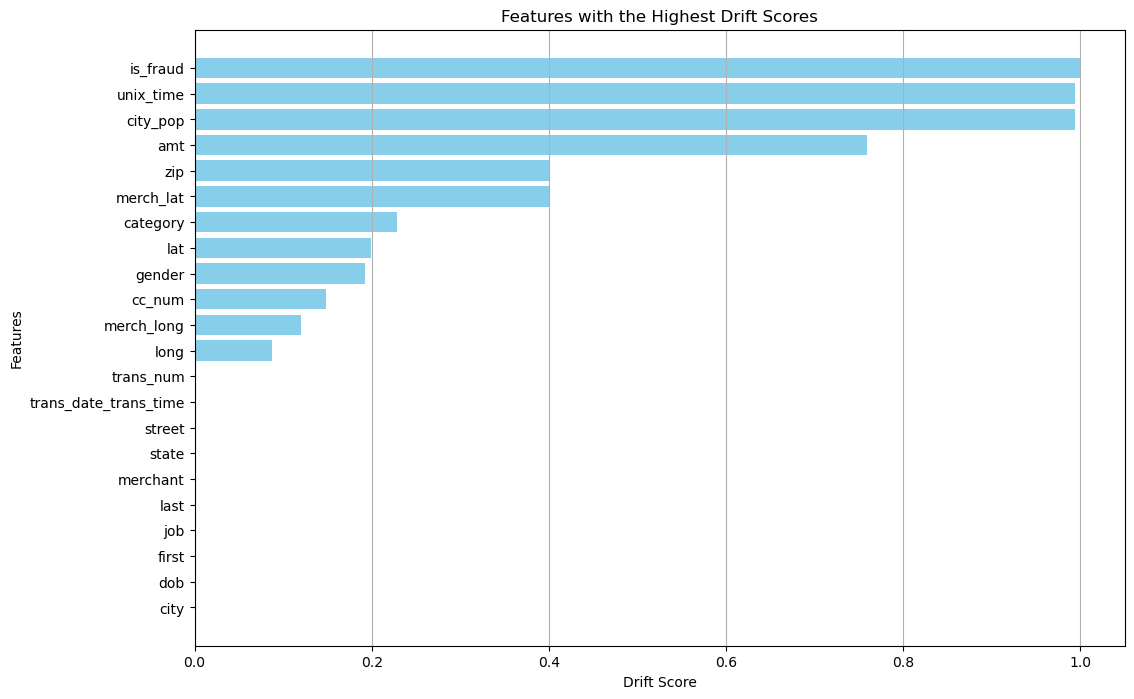

In [19]:
# Extraire les informations de drift
drift_data = data_drift_dict['metrics'][1]['result']['drift_by_columns']

# Trier les colonnes par drift_score (en ordre décroissant)
sorted_drift_data = sorted(drift_data.items(), key=lambda x: x[1]['drift_score'])

# Obtenir les noms des colonnes et leurs scores de drift
columns = [item[0] for item in sorted_drift_data]
drift_scores = [item[1]['drift_score'] for item in sorted_drift_data]

# Afficher les résultats
plt.figure(figsize=(12, 8))
plt.barh(columns, drift_scores, color='skyblue')
plt.xlabel('Drift Score')
plt.ylabel('Features')
plt.title('Features with the Highest Drift Scores')
plt.grid(axis='x')
plt.show()